In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster

In [2]:
t = Table.read('/Users/roz18/git/desi-photoz/test/clustering_results.txt', format='ascii.commented_header')

ra = np.array(t['ra'])
dec = np.array(t['dec'])
density = np.array(t['density'])
counts = np.array(t['count'])
labels = np.array(t['label'])

n_clusters = len(np.unique(labels))
print(len(t), 'pixels')
print(int(np.sum(counts)), 'objects')

5205 pixels
4634978 objects


In [3]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
c = 1/(41253/npix)

pix_id = hp.pixelfunc.ang2pix(NSIDE, ra, dec, lonlat=True)
m = np.zeros(npix)
m[pix_id] = density
m = hp.ma(m)
m.mask = ~np.array(m, dtype=bool)

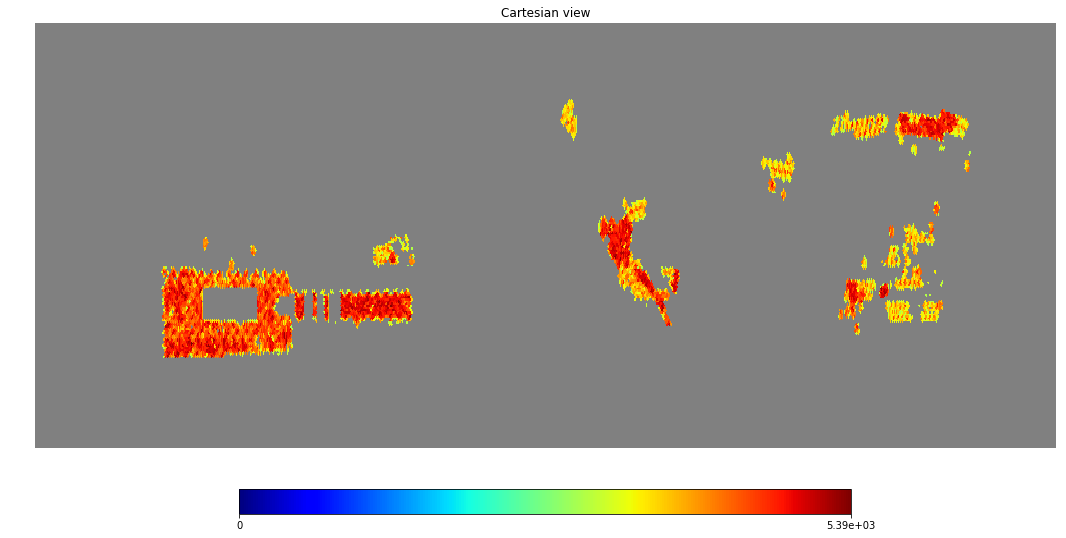

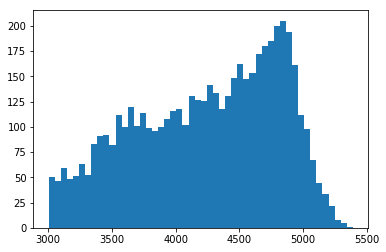

In [4]:
plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m, min=0, rot=(-90, 0, 0), fig=1, latra=(-20, 40), aspect=2.5, xsize=2000)
plt.show()

plt.hist(density, 50)
plt.show()

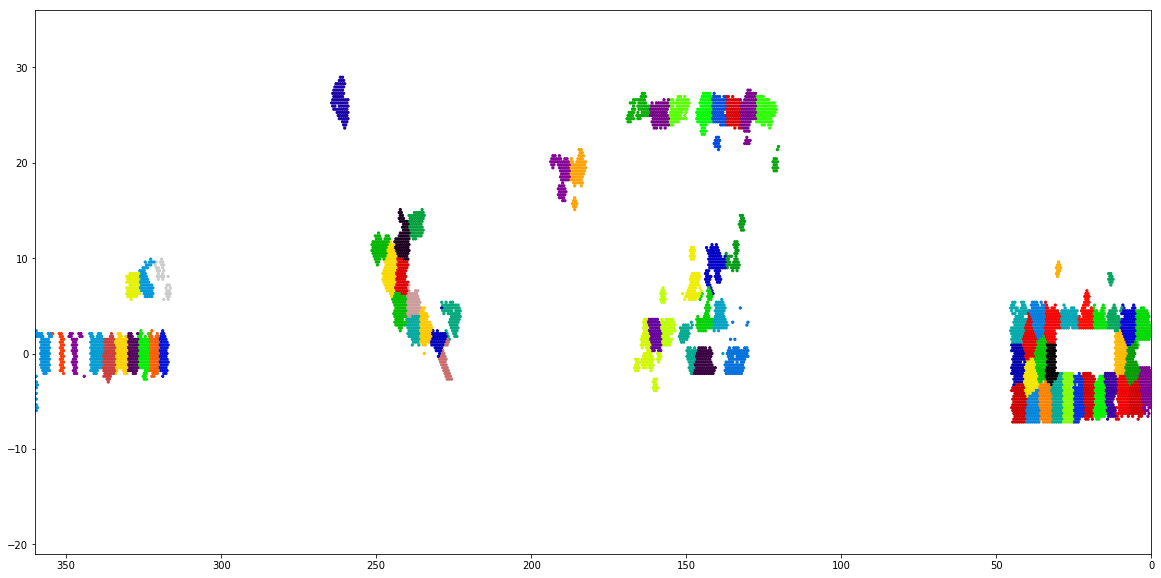

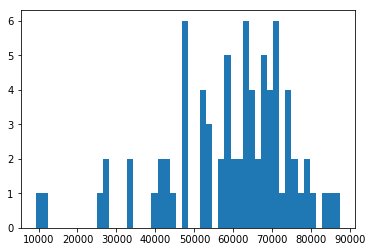

In [5]:
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=labels, cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.show()

group_counts_original = np.zeros(n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(labels==idx_grp)[0]
    group_counts_original[idx_grp] = np.sum(counts[members])
plt.hist(group_counts_original, 50)
plt.show()

__Identify the neighbors of each occupied pixel:__

In [6]:
neighbors = hp.get_all_neighbours(NSIDE, ra, dec, lonlat=True).T
mask = np.in1d(neighbors, pix_id).reshape(neighbors.shape)
neighbors[~mask] = -1

# Convert to native numpy indices of the pixels
# pointer from healpy indices to pixel indices:
pointer = -99 * np.ones(npix, dtype=int)
for index in range(len(ra)):
    pointer[pix_id[index]] = index
neighbors[mask] = pointer[neighbors[mask]]

# # Verify that the neighbor-finding is correct
# plt.figure(figsize=(20, 10))
# plt.plot(ra[neighbors[mask]], dec[neighbors[mask]], '.', markersize=5)
# plt.axis([360, 0, -21, 36])
# plt.show()

In [7]:
# # Find lone pixels
# mask = neighbors>=0
# mask_loner = ~np.any(mask, axis=1)
# print(np.sum(mask_loner), 'lone pixels')
# plt.figure(figsize=(20, 10))
# plt.plot(ra[~mask_loner], dec[~mask_loner], '.', markersize=5)
# plt.plot(ra[mask_loner], dec[mask_loner], 'r.', markersize=5)
# plt.axis([360, 0, -21, 36])
# plt.show()

# # Find bordering pixels
# mask1 = labels[neighbors] != labels[:, None]
# mask2 = neighbors>=0
# mask_border = np.any(mask1 & mask2, axis=1)
# print(np.sum(mask_border), 'bordering pixels')
# plt.figure(figsize=(20, 10))
# plt.plot(ra[~mask_border], dec[~mask_border], '.', markersize=5)
# plt.plot(ra[mask_border], dec[mask_border], 'r.', markersize=5)
# plt.axis([360, 0, -21, 36])
# plt.show()

In [28]:
# Default parameters:
default_params = {
    'pop_size': 50,   # population size
    'surv_rate': 0.5,
    'mutate_rate': 0.0015,
    'ngen': 2000,  # number of generations to run
    'tournament_k':3, # number of individuals in tournament selection
    'equality_weight': 250., # weight of imposing equal weighted pix counts in fitness function
    # 'verbose': True, 
}

In [29]:
from optimized_pixel_partition import Subsampler

# Initialize
optimizer = Subsampler(ra, dec, labels, neighbors, weights=counts, **default_params)

-----------
__Evolve!__

In [30]:
# optimizer.equality_weight = 150.

In [31]:
# np.random.seed(2)

############################## Evolve! ##############################
for idx_gen in range(default_params['ngen']):

    # update the fitness scores
    optimizer.fitness()
    
    # print status
    best = np.argmax(optimizer.scores)
    if idx_gen%10==0:
        print('{:5d} {:11.8g} {:11.8g} {:11.8g}'.\
              format(idx_gen, optimizer.scores[best], optimizer.compactness[best], optimizer.equality[best]))

    # select survivers
    survivers = optimizer.selection()
    
    # rebuild solution array and mutate
    optimizer.labels_all = optimizer.labels_all[survivers]
    optimizer.mutate()

    0    -200.646   134.42872   66.217283
   10  -200.31689   134.50809   65.808797
   20  -199.92308   134.66694   65.256143
   30  -199.60304   134.75013   64.852904
   40  -199.31938   134.86028   64.459102
   50   -198.8688   135.00323    63.86557
   60  -198.60423   135.10671    63.49752
   70  -198.26915   135.21121   63.057947
   80  -197.96047   135.32822   62.632254
   90  -197.72063   135.36669    62.35394
  100  -197.44244   135.43447   62.007976
  110  -197.17847   135.50678   61.671697
  120  -196.88286   135.63698   61.245887
  130  -196.56699    135.6872   60.879786
  140  -196.31844   135.79052   60.527919
  150  -196.12368   135.85466   60.269017
  160  -195.93291   135.88288   60.050034
  170   -195.7596   135.95401   59.805585
  180  -195.51993    135.9531   59.566821
  190  -195.35696   136.03113   59.325832
  200  -195.19356    135.9912   59.202358
  210  -195.07263   136.09223   58.980396
  220  -194.94146   136.19031   58.751149
  230  -194.82986    136.0975   58

 1960  -188.86774   137.77804   51.089706
 1970  -188.86247   137.79802   51.064445
 1980  -188.86021   137.78457   51.075641
 1990   -188.8556   137.77126   51.084338


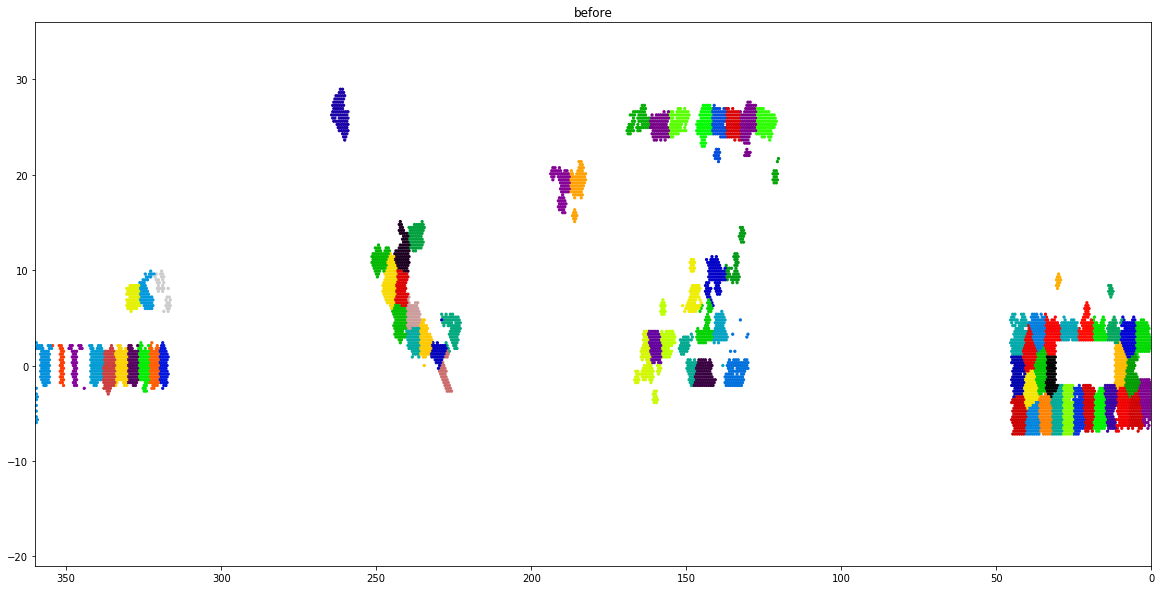

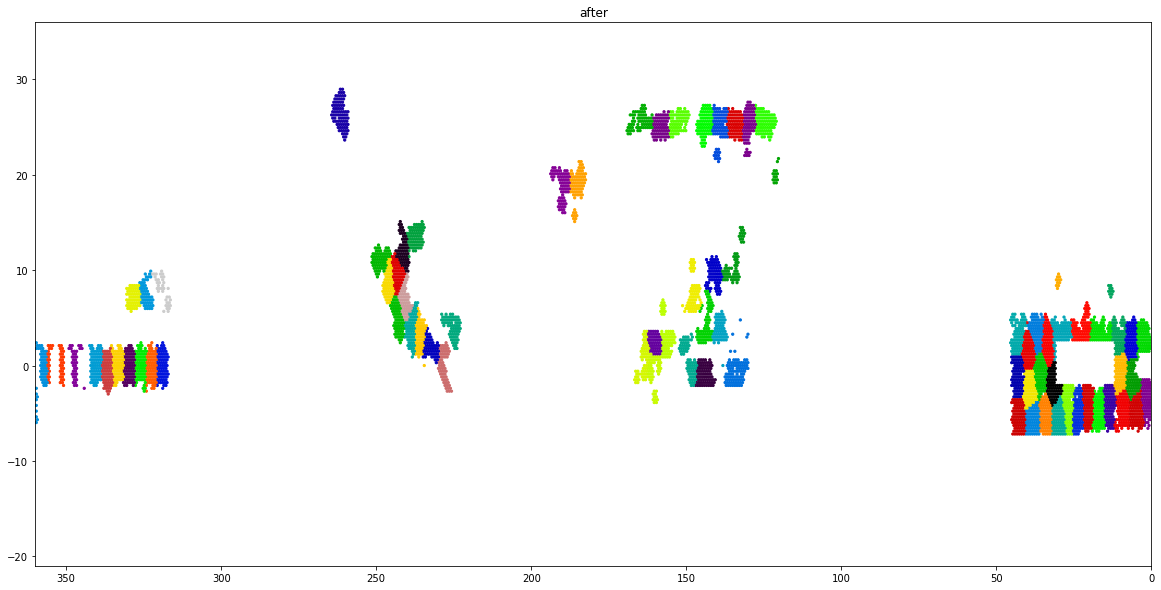

In [36]:
# Original grouping
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=labels, cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.title('before')
plt.show()

# Final grouping
best = np.argsort(optimizer.scores)[-1]
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=optimizer.labels_all[best], cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.title('after')
plt.show()

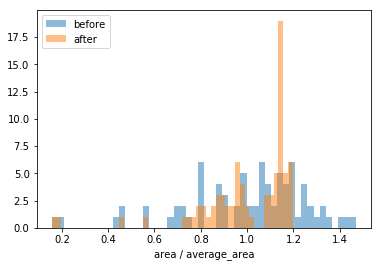

In [41]:
plt.hist(group_counts_original/optimizer.average_count, 50, alpha=0.5, label='before')
plt.hist(optimizer.counts[best]/optimizer.average_count, 50, alpha=0.5, label='after')
plt.legend(loc='upper left')
plt.xlabel('area / average_area')
plt.show()

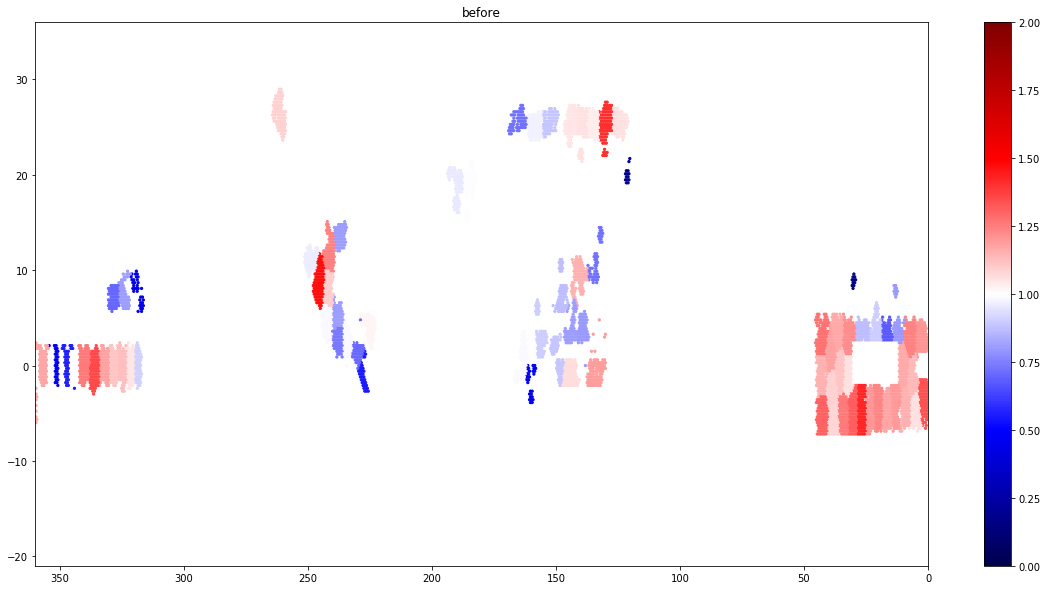

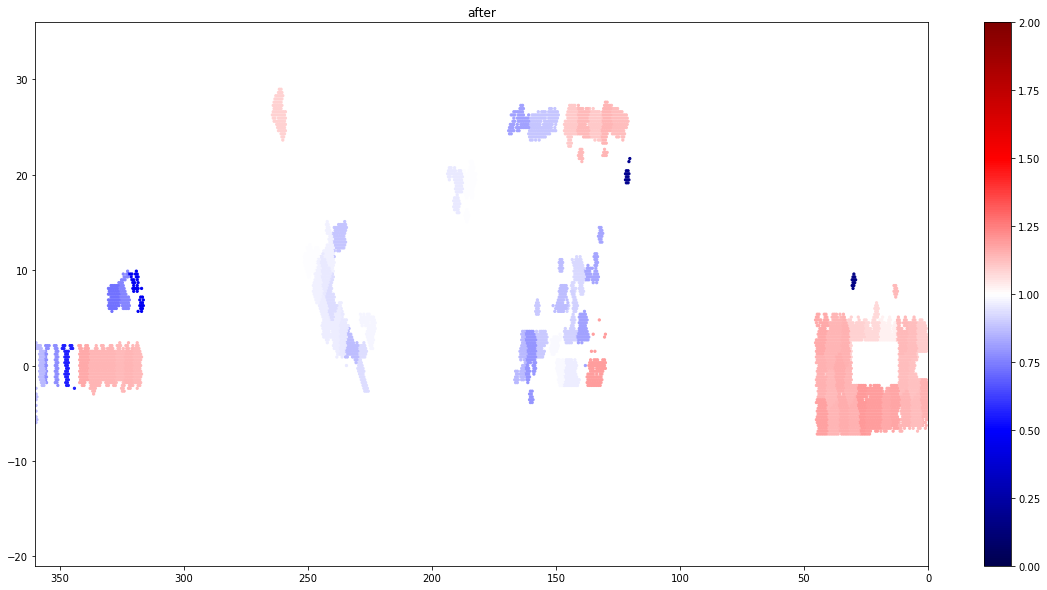

In [38]:
counts_pix_original = group_counts_original[labels]
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=counts_pix_original/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0, vmax=2)
plt.colorbar()
plt.axis([360, 0, -21, 36])
plt.title('before')
plt.show()

counts_pix = optimizer.counts[best][optimizer.labels_all[best]]
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=counts_pix/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0, vmax=2)
plt.colorbar()
plt.axis([360, 0, -21, 36])
plt.title('after')
plt.show()

4 outlier clusters


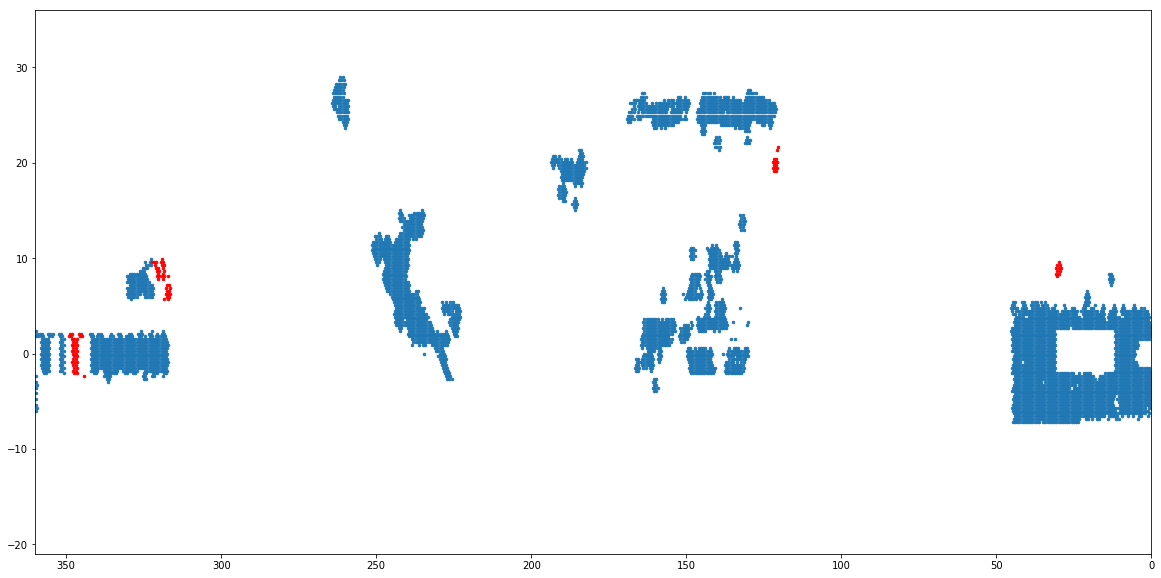

In [35]:
mask_count = optimizer.counts[best]<40000. 
print(np.sum(mask_count), 'outlier clusters')
# print('{:.2f}% objects discarded'.format(np.sum(mask_count)/len(mask_count)*100))
pix_id_ok = np.where(mask_count)[0]
mask_outlier = np.in1d(optimizer.labels_all[best], pix_id_ok)

plt.figure(figsize=(20, 10))
plt.plot(ra[~mask_outlier], dec[~mask_outlier], '.', markersize=5)
plt.plot(ra[mask_outlier], dec[mask_outlier], 'r.', markersize=5)
plt.axis([360, 0, -21, 36])
plt.show()